 # Time-Series Forecasting on MSFT Stock Price
 This projects develops a deep learning moldel (LSTM/RNN) to forcast the Microsoft Corporation Common Stock (MSFT) price. Some pre-processing and exploratory data analysis was conducted first to explore the data. Four different models (SimpleRNN, 1-layer LSTM and 2-layer SLTM with different window sizes) were trained and compared for better performance.  
 ## Summary of results
 The developed model with a 1-layer LSTM architecture forcasts the *close price*  with its prior 60 days *close price* as input. It has a RMSE of 6.85 on the test data set. This may or may not be acceptable depending on specific problems. Using log returns ($ \log \frac{P_t}{P_{t-1}} $) or price difference ($P_t-P_{t-1}$) are alternative methods for the stock price forcast. 
 We can extend this project for real-time streaming data by automating new data ingestion and retraining the model daily for the forcast of the next day's stock price. 

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Seed code to get the same random numbers every time for reproducibility 
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)


# Read the data

The dataset used in this project is downloaded from https://www.nasdaq.com/market-activity/stocks/msft/historical?page=1&rows_per_page=10&timeline=y5. It contains MSFT stock prices from 26/05/2020 to 22/05/2025.

In [141]:
df=pd.read_csv('HistoricalData_MSFT.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/22/2025,$454.86,18025610,$454.95,$460.25,$453.90
1,05/21/2025,$452.57,19216910,$454.57,$457.78,$451.814
2,05/20/2025,$458.17,15441810,$455.59,$458.34,$454.3201
3,05/19/2025,$458.87,21336510,$450.875,$459.585,$450.80
4,05/16/2025,$454.27,23849780,$452.05,$454.36,$448.73


# Data Cleaning and EDA

In [145]:
df.shape

(1256, 6)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1256 non-null   object
 1   Close/Last  1256 non-null   object
 2   Volume      1256 non-null   int64 
 3   Open        1256 non-null   object
 4   High        1256 non-null   object
 5   Low         1256 non-null   object
dtypes: int64(1), object(5)
memory usage: 59.0+ KB


In [147]:
# check null values
df.isna().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [148]:
# change the column 'Close/Last' to 'Close'
df=df.rename(columns={'Close/Last':'Close'})

# change the colume 'Date' to datetime and set as index
df['Date']=pd.to_datetime(df['Date'],format='%m/%d/%Y')
df=df.set_index('Date').sort_index()
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2020-05-26,$181.57,36073610,$186.34,$186.50,$181.10
2020-05-27,$181.81,39517150,$180.20,$181.9877,$176.60
2020-05-28,$181.40,33831820,$180.74,$184.1474,$180.38
2020-05-29,$183.25,42146720,$182.73,$184.27,$180.41
2020-06-01,$182.83,22668820,$182.54,$183.00,$181.46


In [149]:
# Remove the $ signs and convert the string datatype columns to float
df['Close']=df['Close'].str.replace('$','').astype(float)
df['Open']=df['Open'].str.replace('$','').astype(float)
df['High']=df['High'].str.replace('$','').astype(float)
df['Low']=df['Low'].str.replace('$','').astype(float)

df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2020-05-26,181.57,36073610,186.34,186.5000,181.10
2020-05-27,181.81,39517150,180.20,181.9877,176.60
2020-05-28,181.40,33831820,180.74,184.1474,180.38
2020-05-29,183.25,42146720,182.73,184.2700,180.41
2020-06-01,182.83,22668820,182.54,183.0000,181.46


In [156]:
df['Year']=df.index.year
df['Month']=df.index.month
df['Weekday_name']=df.index.day_name()
df.head()

,Close,Volume,Open,High,Low,Year,Month,Weekday_name
Date,,,,,,,,
2020-05-26,181.57,36073610,186.34,186.5000,181.10,2020,5,Tuesday
2020-05-27,181.81,39517150,180.20,181.9877,176.60,2020,5,Wednesday
2020-05-28,181.40,33831820,180.74,184.1474,180.38,2020,5,Thursday
2020-05-29,183.25,42146720,182.73,184.2700,180.41,2020,5,Friday
2020-06-01,182.83,22668820,182.54,183.0000,181.46,2020,6,Monday


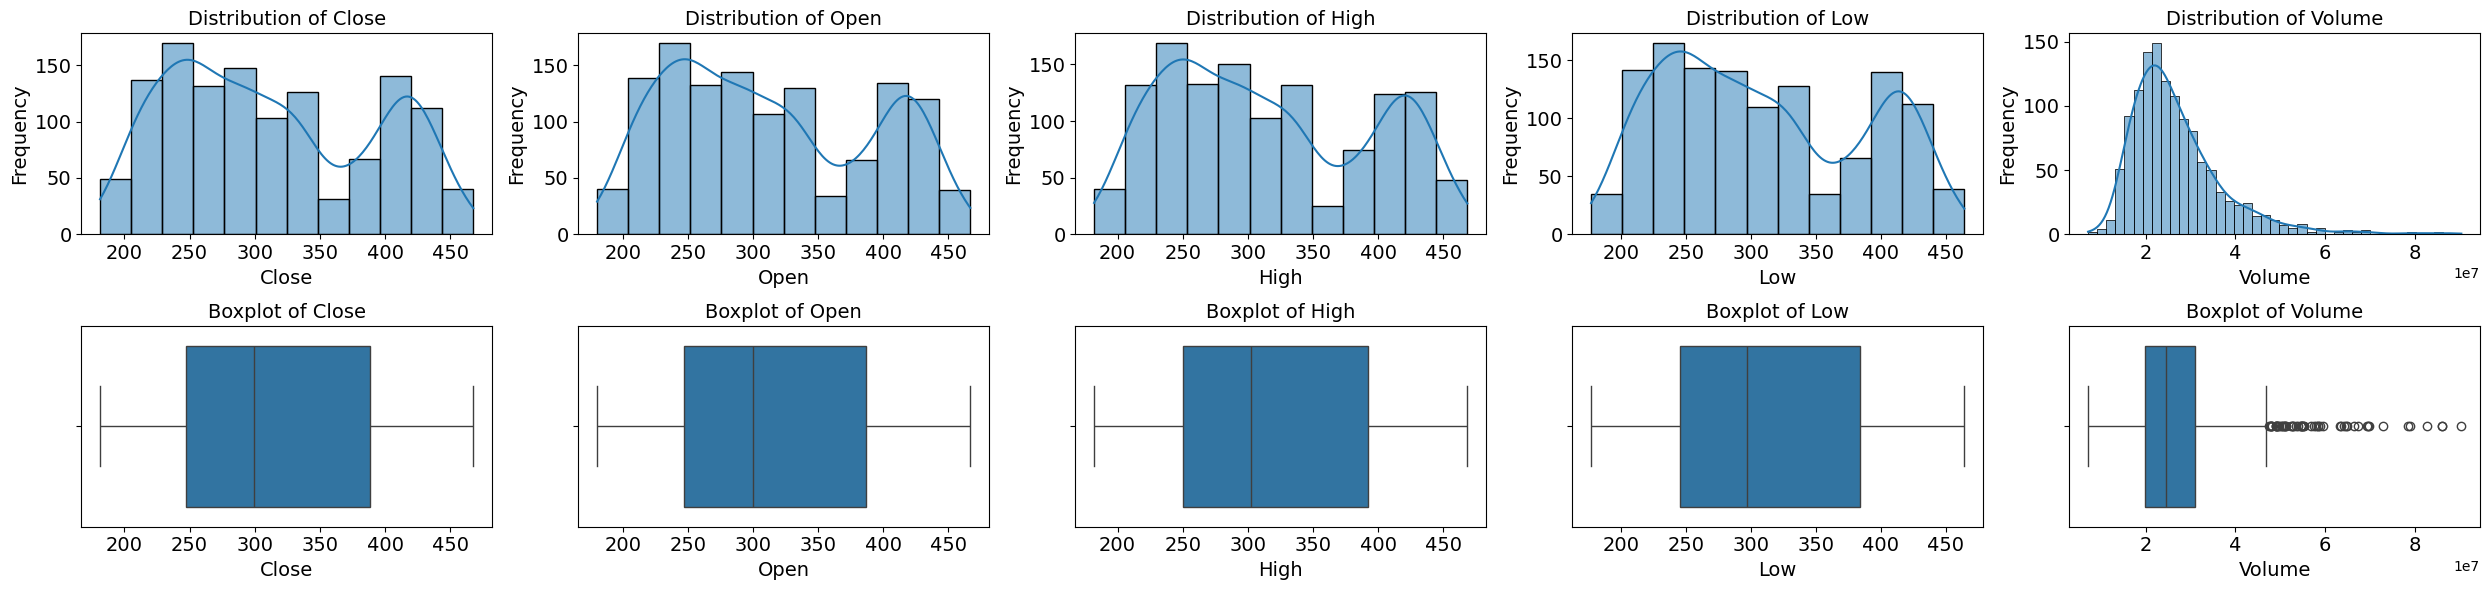

In [157]:
# visualize distribution of cho columns and detect any outliers 
numerical_cols = ['Close', 'Open', 'High', 'Low','Volume'] # select numerical columns

# Set up grid size (2 rows: histogram + boxplot per column)
n = len(numerical_cols)
cols = 5  # number of columns in the grid
rows = (n + cols - 1) // cols  # ceiling division

fig, axes = plt.subplots(rows * 2, cols, figsize=(cols * 5, rows * 2 * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].tick_params(axis='both', labelsize=14)  # Set tick font size
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    
    # Boxplot directly below the histogram
    sns.boxplot(x=df[col], ax=axes[i + n])
    axes[i + n].set_title(f'Boxplot of {col}',fontsize=14)
    axes[i+n].tick_params(axis='both', labelsize=14)  # Set tick font size
    axes[i+n].set_xlabel(col, fontsize=14)
# Hide unused subplots
for j in range(2 * n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* There are no outliers in the Close, Open, High and Low values. The histograms of Close, Open, High, and Low are similar. 
* The volume distribution is Right-Skewed, having extremely large outliers.  



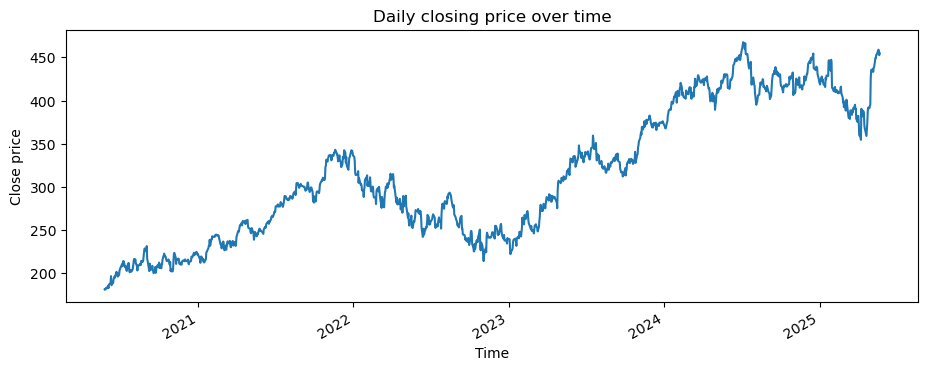

In [154]:
# Plot the daily price history 
plt.figure(figsize=(11,4))
df['Close'].plot()
plt.title("Daily closing price over time")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()

In [160]:
# check weekly trend
# get the Close price on Fridays
df_weekly=df[df['Weekday_name']=='Friday']
df_weekly.head()

,Close,Volume,Open,High,Low,Year,Month,Weekday_name
Date,,,,,,,,
2020-05-29,183.25,42146720,182.73,184.27,180.41,2020,5,Friday
2020-06-05,187.20,39893640,182.62,187.73,182.01,2020,6,Friday
2020-06-12,187.74,43373590,190.54,191.72,185.18,2020,6,Friday
2020-06-19,195.15,44441140,198.59,199.29,194.37,2020,6,Friday
2020-06-26,196.33,54675780,199.73,199.89,194.88,2020,6,Friday


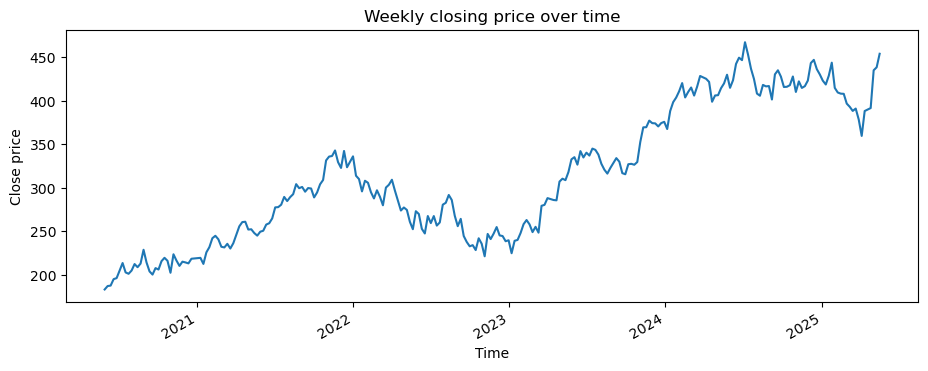

In [161]:

df_weekly=df[df['Weekday_name']=='Friday']
# Plot theweekly price history 
plt.figure(figsize=(11,4))
df_weekly['Close'].plot()
plt.title("Weekly closing price over time")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()

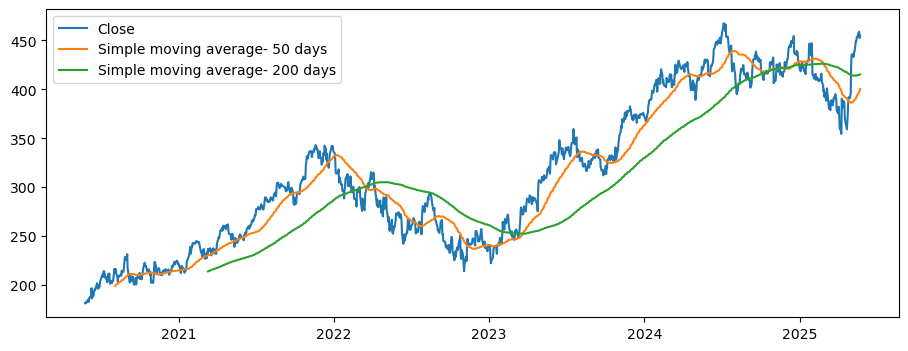

In [49]:
# Check simple moving average price
df['SMA_50'] =df['Close'].rolling(50).mean().shift() #The average of the past 50 days, not including today’s value, This is common for backtesting or preventing lookahead bias.
df['SMA_200'] =df['Close'].rolling(200).mean().shift()
# df.head(20)
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(df['Close'],label='Close')
ax.plot(df['SMA_50'],label='Simple moving average- 50 days')
ax.plot(df['SMA_200'],label='Simple moving average- 200 days')
ax.legend()

# Prepare the data for modelling

In [308]:
#  Split the original (unscaled) series first
train_size = int(len(df['Close']) * 0.6)
val_size = int(len(df['Close']) * 0.2)
test_size = len(df['Close']) - train_size - val_size

train_raw = df['Close'].values[:train_size].reshape(-1, 1)
val_raw = df['Close'].values[train_size:train_size+val_size].reshape(-1, 1)
test_raw = df['Close'].values[train_size+val_size:].reshape(-1, 1)

# Fit scaler only on training data
scaler = MinMaxScaler()
scaler.fit(train_raw)

# Transform all splits using the SAME scaler
train_data = scaler.transform(train_raw)
val_data = scaler.transform(val_raw)
test_data = scaler.transform(test_raw)

# check shapes
print(train_data.shape, val_data.shape, test_data.shape)


(753, 1) (251, 1) (252, 1)


In [309]:
# Prepare the data for LSTM
# Transform datasets into X and y variables using the windowing technique
def create_dataset(data, time_step=1):
# data:a 2D NumPy array 
# time_step: number of previous time steps to use for predicting the next one
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(X_train.shape, X_val.shape, X_test.shape)

(722, 30) (220, 30) (221, 30)


In [310]:
# Reshape input to be [samples, time_steps, features] as required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_val.shape, X_test.shape)

(722, 30, 1) (220, 30, 1) (221, 30, 1)


# Model construction
For a deep RNN architecture, we need to choose the depth (i.e, the number of layers the RNN has — e.g. stacking multiple LSTM or GRU layers on top of each other) and the neurons per layer (i.e., the number of units each RNN layer has — controls the layer’s capacity to learn patterns in sequences). 
Usually, a depth of 1–3 layers is sufficient for many problems. 
Typical number of units per layer are 32, 50, 64, 128, depending on data and compute. Too deep or too wide can cause overfitting or slow training — so we tune these by experimenting + validation.

## 1.SimpleRNN model 

Input → simpleRNN(32)   
      → Dense(16) → Dense(1)


In [315]:
# Build a simple RNN model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(SimpleRNN(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [316]:
# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10)
model.summary()

Epoch 1/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0115
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0012
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_18 (SimpleRNN)            │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,901 (19.15 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,268 (12.77 KB)

In [317]:
# Predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [318]:
# Evaluate the model
train_scaled_mse = mean_squared_error(y_train, train_predict)
print(f'Train_scaled MSE: {train_scaled_mse}')
val_scaled_mse = mean_squared_error(y_val, val_predict)
print(f'Val_scaled MSE: {val_scaled_mse}')

train_scaled_r2 = r2_score(y_train, train_predict)
print(f'Train_scaled r2: {train_scaled_r2}')
val_scaled_r2 = r2_score(y_val, val_predict)
print(f'Val_scaled r2: {val_scaled_r2}')

Train_scaled MSE: 0.0016071902273613633
Val_scaled MSE: 0.001429694605001172
Train_scaled r2: 0.9677724613033309
Val_scaled r2: 0.9724457320219244


In [303]:
model.save('simpleRNN_model.h5')

* The SimpleRNN model fits the data well, with $R^2$ of 0.968 and 0.972 for the train and validation datasets respectively.

## 2.LSTM model (1 layer): 
Input → LSTM(32)   
      → Dense(16) → Dense(1)


In [311]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [312]:
# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10)
model.summary()

Epoch 1/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0267
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0017
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0015
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0014
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0013
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0012
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0012
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0011


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)

In [313]:
# Predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [314]:
# evaluate
train_scaled_mse = mean_squared_error(y_train, train_predict)
print(f'Train_scaled MSE: {train_scaled_mse}')
val_scaled_mse = mean_squared_error(y_val, val_predict)
print(f'Val_scaled MSE: {val_scaled_mse}')

train_scaled_r2 = r2_score(y_train, train_predict)
print(f'Train_scaled r2: {train_scaled_r2}')
val_scaled_r2 = r2_score(y_val, val_predict)
print(f'Val_scaled r2: {val_scaled_r2}')

Train_scaled MSE: 0.0012708652595141245
Val_scaled MSE: 0.0010532484196916325
Train_scaled r2: 0.974516483094546
Val_scaled r2: 0.9797009171733958


In [276]:
model.save('lstm_model_1layer.h5')

* Compred to the 1-layer SimpleRNN model, the 1-layer LSTM model performs better, with $R^2$ of 0.975 and 0.979 for the training and validation datasets respectively. 

## 3.LSTM model (2 layers):
Input → LSTM(32, return_sequences=True)
      → LSTM(32)
      → Dense(16) → Dense(1)

In [319]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [320]:
# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10)
model.summary()

Epoch 1/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0244
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0042
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0030
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0022
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0018
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0016
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0015
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0015
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0014
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0013


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                       │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_55 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,653 (154.90 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,436 (103.27 KB)

In [321]:
# Predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [322]:
# evaluate
train_scaled_mse = mean_squared_error(y_train, train_predict)
print(f'Train_scaled MSE: {train_scaled_mse}')
val_scaled_mse = mean_squared_error(y_val, val_predict)
print(f'Val_scaled MSE: {val_scaled_mse}')

train_scaled_r2 = r2_score(y_train, train_predict)
print(f'Train_scaled r2: {train_scaled_r2}')
val_scaled_r2 = r2_score(y_val, val_predict)
print(f'Val_scaled r2: {val_scaled_r2}')

Train_scaled MSE: 0.002246583563663955
Val_scaled MSE: 0.0019478458213666816
Train_scaled r2: 0.9549512823680193
Val_scaled r2: 0.9624594892124753


* The 2-layer LSTM model performance doesn't improve comprared to the 1-layer LSTM model. So 1-layer LSTM model is sufficient for this problem. 

## 4.1-layer LSTM model - Adjust the widow_size

The window size can affect the result too. Here we optimise the window size for the 1-layer LSTM model. 

In [323]:
# Set the desired window size
time_step =60
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time_steps, features] as required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10)
model.summary()

Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0139
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0024
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0018
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0016
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0014
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0013
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0013
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0012
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0012
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0012


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)

In [324]:
# Predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

# evaluate
train_scaled_mse = mean_squared_error(y_train, train_predict)
print(f'Train_scaled MSE: {train_scaled_mse}')
val_scaled_mse = mean_squared_error(y_val, val_predict)
print(f'Val_scaled MSE: {val_scaled_mse}')

train_scaled_r2 = r2_score(y_train, train_predict)
print(f'Train_scaled r2: {train_scaled_r2}')
val_scaled_r2 = r2_score(y_val, val_predict)
print(f'Val_scaled r2: {val_scaled_r2}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train_scaled MSE: 0.0010527408128213496
Val_scaled MSE: 0.0009495939563643075
Train_scaled r2: 0.9776473873329786
Val_scaled r2: 0.98116388444297


* By changing the window size from 30 to 60, the performance is slightly improved. We will use this model as the final model.

## Retrain the selected model (1-layer LSTM model) 
We will retrain the selected model (1 layer LSTM, window size 60) on the combined training and validation datasets.

In [363]:
# Prepare the dataset for training

# Redefine split sizes
trainval_size = train_size + val_size  # old train + val
test_size = len(df['Close']) - trainval_size
# Extract raw data
trainval_raw = df['Close'].values[:trainval_size].reshape(-1, 1)
test_raw = df['Close'].values[trainval_size:].reshape(-1, 1)
# Fit scaler on the new bigger training set
scaler = MinMaxScaler()
scaler.fit(trainval_raw)
# Transform both splits
trainval_data = scaler.transform(trainval_raw)
test_data = scaler.transform(test_raw)
print(trainval_data.shape, test_data.shape)

time_step =60
X_train_full, y_train_full = create_dataset(trainval_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape )

# Reshape input to be [samples, time_steps, features] as required by LSTM
X_train_full = X_train_full.reshape(X_train_full.shape[0], X_train_full.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train_full.shape,  X_test.shape)

(1004, 1) (252, 1)
(943, 60) (943,) (191, 60) (191,)
(943, 60, 1) (191, 60, 1)


In [364]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(X_train_full, y_train_full, batch_size=1, epochs=10)
model.summary()

Epoch 1/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0077
Epoch 2/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0011
Epoch 3/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.8913e-04
Epoch 4/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 7.6039e-04
Epoch 5/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.6893e-04
Epoch 6/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.0907e-04
Epoch 7/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5.6460e-04
Epoch 8/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 5.2606e-04
Epoch 9/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5.0847e-04
Epoch 10/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 4.9484e-04


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_58 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)

In [365]:
# Predictions
train_full_predict = model.predict(X_train_full)
test_predict = model.predict(X_test)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


# Evaluate the model performance

In [366]:
# evaluate RMSE and MAE of the scaled values
train_full_scaled_mse = mean_squared_error(y_train_full, train_full_predict)
print(f'Train_scaled MSE: {train_full_scaled_mse}')

train_full_scaled_r2 = r2_score(y_train_full, train_full_predict)
print(f'Train_full_scaled r2: {train_full_scaled_r2}')

Train_scaled MSE: 0.0003792556466946313
Train_full_scaled r2: 0.9929643160397162


In [367]:
# Calculate RMSE and MAE of the unscaled values

#  Inverse transform to get actual values
train_full_predict_unscaled = scaler.inverse_transform(train_full_predict)
test_predict_unscaled = scaler.inverse_transform(test_predict)
y_train_full_unscaled = scaler.inverse_transform(y_train_full.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1))

train_rmse = np.sqrt(mean_squared_error(y_train_full_unscaled, train_full_predict_unscaled))
train_mae = mean_absolute_error(y_train_full_unscaled, train_full_predict_unscaled)

test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, test_predict_unscaled))
test_mae = mean_absolute_error(y_test_unscaled, test_predict_unscaled)

print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}')
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}')

Train RMSE: 4.829088047906532, Train MAE: 3.680330334174924
Test RMSE: 6.853147046325238, Test MAE: 4.599330645656088


In [368]:
# Un-window the training predictions
plot_train_predict = np.empty_like(scaled_data)
plot_train_predict[:] = np.nan
plot_train_predict[time_step:len(train_full_predict_unscaled) + time_step, :] = train_full_predict_unscaled

# Un-window the test predictions
plot_test_predict = np.empty((len(df), 1))
plot_test_predict[:] = np.nan
plot_test_predict[len(train_full_predict_unscaled) +  (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict_unscaled

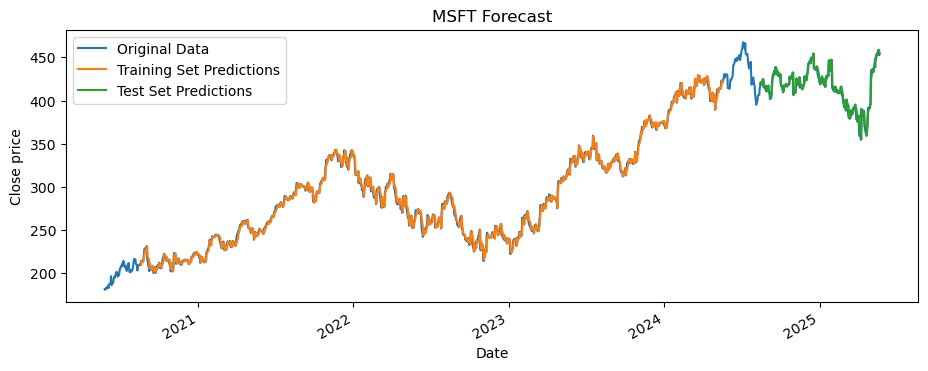

In [369]:
# Plot the original data
plt.figure(figsize=(11,4))
plt.plot(df.index, df['Close'], label="Original Data")

# Plot the predictions
plt.plot(df.index, plot_train_predict[:,0], label="Training Set Predictions")
plt.plot(df.index, plot_test_predict[:,0], label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('MSFT Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Close price')
plt.legend()
plt.show()

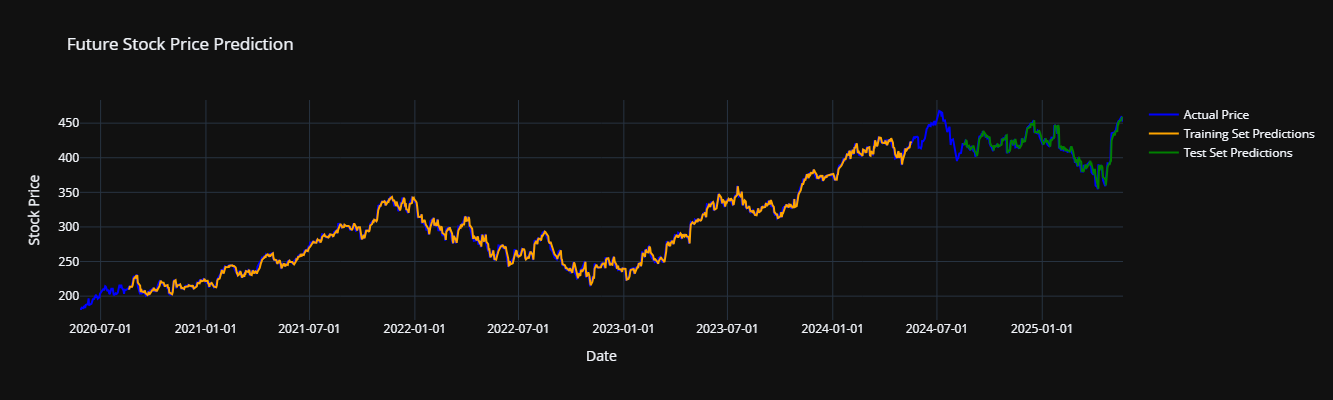

In [370]:
# Create an interactive visulization with Plotly
fig = go.Figure()
fig.update_layout(width=1100, height=400)
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Actual Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=plot_train_predict[:, 0], mode='lines', name="Training Set Predictions", line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=plot_test_predict[:, 0], mode='lines', name="Test Set Predictions", line=dict(color='green')))
fig.update_layout(
    title='Future Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    template='plotly_dark',
    xaxis=dict(
        tickformat='%Y-%m-%d',
        hoverformat='%Y-%m-%d'
    )
)
fig.show()

# Make predictions for the future

In [372]:
def predict_future(model, data, scaler, time_step=60, future_steps=10):
    # Prepare the input data for future prediction
    last_data = data[-time_step:]
    last_data = last_data.reshape(1, time_step, 1)

    # Predict future prices
    future_predictions = []
    for _ in range(future_steps):
        next_pred = model.predict(last_data)
        future_predictions.append(next_pred[0, 0])
        last_data = np.append(last_data[:, 1:, :], [[[next_pred[0, 0]]]], axis=1)  # Each new predicted value is appended back as input to predict the next step 

    # Inverse transform the predictions to get actual values
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

# Example usage
future_steps = 10
future_predictions = predict_future(model, test_data, scaler, time_step, future_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


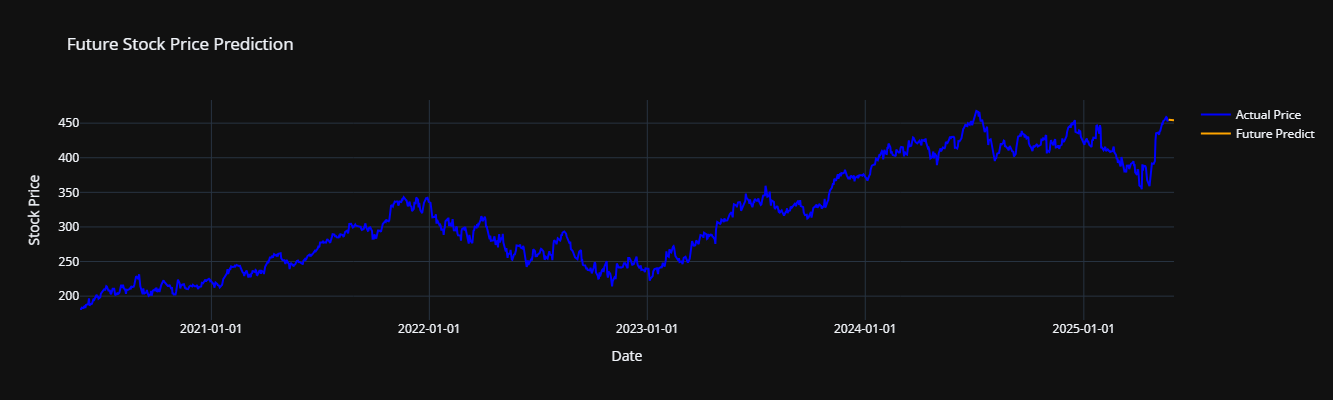

In [373]:
# Plotting future predictions
fig = go.Figure()
fig.update_layout(width=1100, height=400)
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Actual Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions[:, 0], mode='lines', name='Future Predict', line=dict(color='orange')))
fig.update_layout(
    title='Future Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    template='plotly_dark',
    xaxis=dict(
        tickformat='%Y-%m-%d',
        hoverformat='%Y-%m-%d'
    )
)
fig.show()

* Each predicted value is fed back into the input for the next prediction. If a prediction is slightly off, that error propagates and often amplifies over subsequent steps. This causes the forecast to “drift” away from reality as we predict farther into the future. No mechanism here to adapt or retrain on new data as predictions move forward.
* We can  collect and append daily new data to the existing historical dataset. Then schedule a pipeline for daily retraining the model for the forcast of next day's stock price

# Conclusions
Time-Series Forecasting on stock price with LSTM/RNN model is demonstrated in this project. The optimision of the model is conducted to improve the prediction accuracy. A simple 1-layer LSTM architecture forcasts the *close price*  accurately with its prior 60 days *close price* as input, achieving a RMSE of 6.85 on the test data set. It has a RMSE of 6.85 on the test data set. This may or may not be acceptable depending on specific problems. Using log returns ($ \log \frac{P_t}{P_{t-1}} $) or price difference ($P_t-P_{t-1}$) are alternative methods for the stock price forcast. 

We can extend this project for real-time streaming data by automating new data ingestion and retraining the model daily for the forcast of the next day's stock price.